In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
os.chdir("..")

os.chdir('/Users/kuldeepchinwan/Projects/ML_Projects/Gurugram_house_Prediction/Data')

current_path = os.getcwd()

In [3]:
house_df = pd.read_csv('housing_clean.csv')

In [4]:
# Define predictors (features) and target variable
X = house_df[['bedRoom', 'bathroom', 'noOfFloor', 'area_value', 'balcony_count',
        'agePossession_numeric', 'Environment_Rating', 'Lifestyle_Rating',
        'Safety_Rating', 'Connectivity_Rating']]  

y = house_df['price']

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

models = {
    "Linear Regression": model,
    "Ridge Regression": Ridge(alpha=1),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
}

for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: R² Score = {r2:.3f}, MSE = {mse:.2f}")


Linear Regression: R² Score = 0.514, MSE = 6.18
Ridge Regression: R² Score = 0.514, MSE = 6.18
Lasso Regression: R² Score = 0.514, MSE = 6.19
Decision Tree: R² Score = 0.474, MSE = 6.69
Random Forest: R² Score = 0.626, MSE = 4.75
XGBoost: R² Score = 0.656, MSE = 4.38



**Model Performance Summary:**
| Model | R² Score | MSE | Remarks |
|---|---|---|---|
| **Linear Regression**   | 0.514 | 6.18 | Poor performance, cannot capture complex patterns |
| **Ridge Regression**    | 0.514 | 6.18 | Similar to Linear Regression |
| **Lasso Regression**    | 0.514 | 6.19 | No improvement, features not strongly affecting target |
| **Decision Tree**       | 0.499 | 6.38 | Overfitting, not generalizing well |
| **Random Forest**       | 0.626 | 4.75 | Good performance, reduces overfitting |
| **XGBoost**             | **0.656** | **4.38** |  **Best Model**, highest accuracy |


***Tunning XGBoost for best results***

**Important Hyperparameters in XGBoost**

|Hyperparameter	  |Function	   |Effect |
| --| ---| ---|
|n_estimators	  |Number of boosting rounds (trees)	  |More trees = better learning, but too many can overfit |
|max_depth	      |Maximum depth of trees	              |Higher depth = more complex patterns, but risk of overfitting|
|learning_rate    |	Shrinks feature impact in each boosting step	|Lower values need more trees but improve generalization|
|subsample	|Fraction of data used per boosting step	|Helps prevent overfitting|
|colsample_bytree	|Fraction of features used for each tree	|Reduces correlation between trees|
|gamma	|Minimum loss reduction to make a split	|Higher values prevent overfitting|


In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7],  # Depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.8, 1],  # Fraction of data used
    'colsample_bytree': [0.8, 1]  # Fraction of features used
}

xgb = XGBRegressor()
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1}


In [8]:
# now we assume best_model would be the model we need

best_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [9]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train R² Score: {r2_train:.4f}")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train R² Score: 0.8065
Test R² Score: 0.6257
Train MSE: 2.3998
Test MSE: 4.7636


model's results show some overfitting because the Train R² (0.8065) is significantly higher than Test R² (0.6257). This means the model is performing well on training data but struggling on unseen data.

In [10]:
#restesting the model with tunning hyperparamters
test_best_model = XGBRegressor(
    colsample_bytree=0.8, 
    learning_rate=0.02, 
    max_depth=4, 
    n_estimators=250, 
    subsample=1
)
test_best_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred = test_best_model.predict(X_train)
y_test_pred = test_best_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train R² Score: {r2_train:.4f}")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train R² Score: 0.9003
Test R² Score: 0.6639
Train MSE: 1.2362
Test MSE: 4.2770


In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(test_best_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")


Cross-Validation R² Scores: [0.7042547  0.66866662 0.50729656 0.79307638 0.78791087]
Mean CV R² Score: 0.6922


****test_best_model works better than best model****

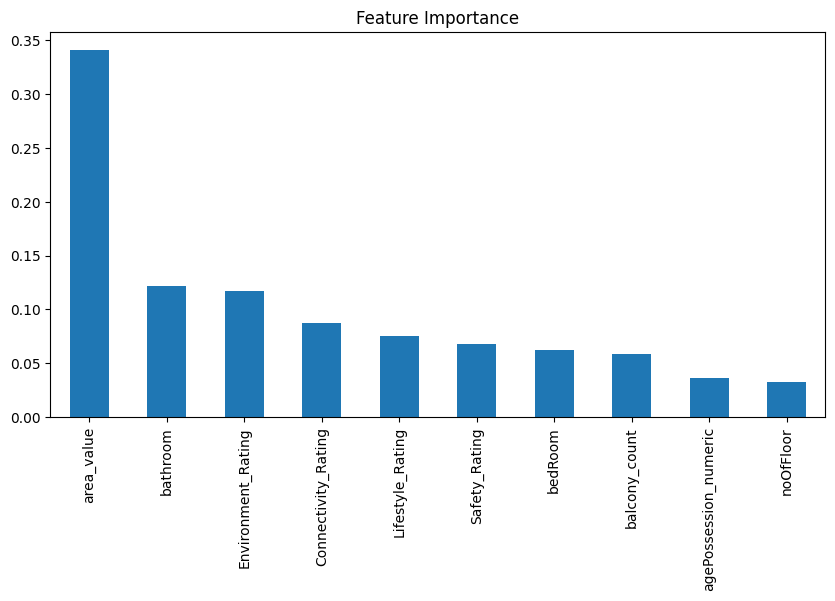

In [12]:
# Get feature importance from the best model
feature_importance = pd.Series(test_best_model.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title="Feature Importance")
plt.show()

In [13]:
# Select numerical columns only
numerical_features = X_train.select_dtypes(include=['int64', 'float64'])

# Compute skewness for each feature
skew_values = numerical_features.apply(skew).sort_values(ascending=False)

# Display skewness values
print(skew_values)

area_value               0.792212
bedRoom                  0.745461
bathroom                 0.518022
Safety_Rating            0.417732
Lifestyle_Rating         0.412284
noOfFloor                0.095029
agePossession_numeric   -0.041282
Environment_Rating      -0.382038
Connectivity_Rating     -0.841154
balcony_count           -0.966285
dtype: float64


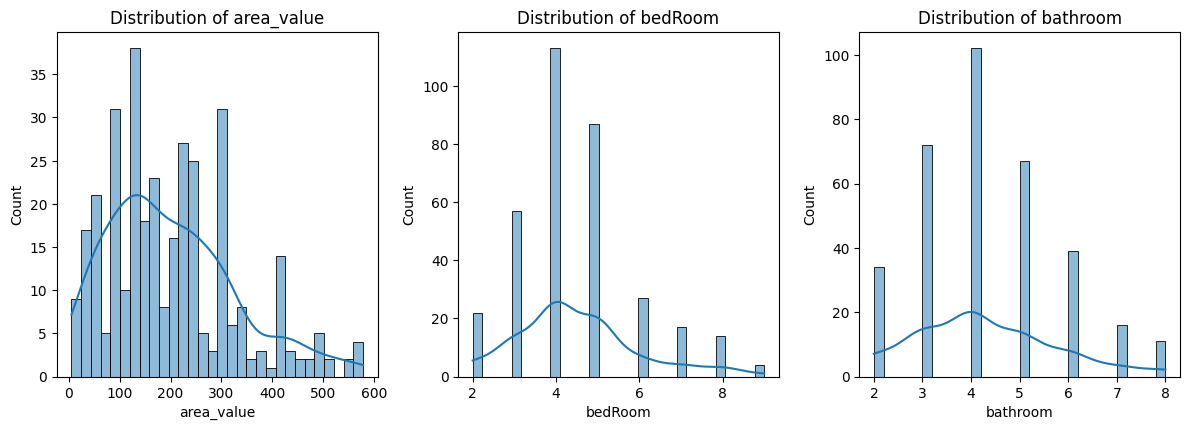

In [14]:
# Plot distribution of top 5 most skewed features
skewed_features = skew_values[skew_values > 0.5].index  # Only right-skewed features

plt.figure(figsize=(12, 8))
for i, feature in enumerate(skewed_features[:5]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

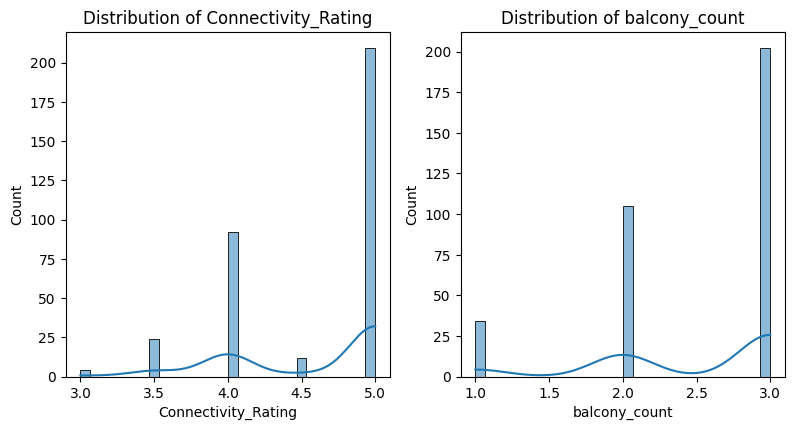

In [15]:
# Plot distribution of top 5 most skewed features
skewed_features = skew_values[skew_values < -0.5].index  # Only right-skewed features

plt.figure(figsize=(12, 8))
for i, feature in enumerate(skewed_features[:5]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

In [16]:
# Log transformation for right-skewed features
right_skewed_features = ['area_value', 'bedRoom', 'bathroom']
for feature in right_skewed_features:
    X_train[feature] = np.log1p(X_train[feature])
    X_test[feature] = np.log1p(X_test[feature])

# Square transformation for left-skewed features
left_skewed_features = ['Connectivity_Rating', 'balcony_count']
for feature in left_skewed_features:
    X_train[feature] = np.square(X_train[feature])
    X_test[feature] = np.square(X_test[feature])

In [17]:
test_best_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred = test_best_model.predict(X_train)
y_test_pred = test_best_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train R² Score: {r2_train:.4f}")
print(f"Test R² Score: {r2_test:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Train R² Score: 0.9003
Test R² Score: 0.6639
Train MSE: 1.2362
Test MSE: 4.2770


No improvement in the model after transforming the skew features

In [21]:
# Save the best model (e.g., test_best_model  --XGBoost)
best_model = grid_search.best_estimator_  # Make sure to use your tuned model

# Save model as a pickle file
with open("../models/xgboost_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Model saved successfully!")

Model saved successfully!
